tgb - 2/11/2020 - The goal of this notebook is to:  
1) Check if the data can be nicely separated using sensible heat flux or surface buoyancy flux  
2) See if normalizing by LHF/SHF helps transform the interporlation problem into an extrapolation problem  
3) Introduce custom layers to separate the data in two based on surface buoyancy fluxes and normalize by LHF/SHF depending on if we are in a turbulence and/or convective regime  
4) Compare the performances of the resulting network with the input-normalized NN

# Imports

In [3]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W0213 17:32:47.801988 23316256601920 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0213 17:32:47.803020 23316256601920 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W0213 17:32:47.803699 23316256601920 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# Data analysis

## Data from (-4K) and (+4K) climate

In [4]:
path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                          decode_times=False)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [5]:
path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                           decode_times=False)

In [19]:
datam4K.PHQ.shape

(432, 30, 64, 128)

In [20]:
datam4K.SHFLX.shape

(432, 64, 128)

## Playing with different variables that could be promising

### Using sensible heat flux

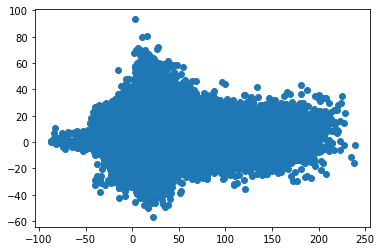

In [24]:
plt.scatter(datam4K.SHFLX,datam4K.TPHYSTND[:,-5,:,:]*24*3600)

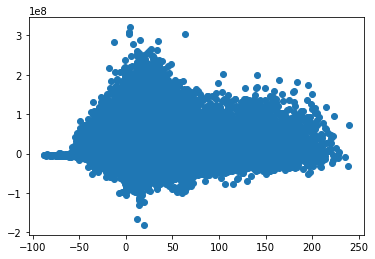

In [25]:
plt.scatter(datam4K.SHFLX,2.5e6*datam4K.TPHYSTND[:,-10,:,:]*24*3600)

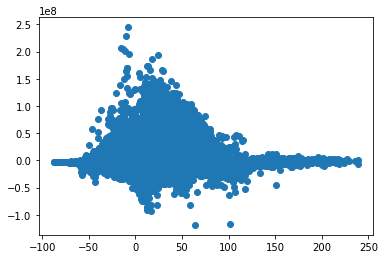

In [26]:
plt.scatter(datam4K.SHFLX,2.5e6*datam4K.TPHYSTND[:,-15,:,:]*24*3600)

In [66]:
datam4K.lev[18]

<xarray.DataArray 'lev' ()>
array(524.687175)
Coordinates:
    lev      float64 524.7
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [96]:
x = datam4K.SHFLX[:,26:40,:].values.flatten()
y = datam4K.TPHYSTND[:,18,26:40,:].values.flatten()
HIST,xedg,yedg = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:2: RuntimeWarning: divide by zero encountered in log10
  # Generated by: tensorflow/python/tools/api/generator/create_python_api.py script.


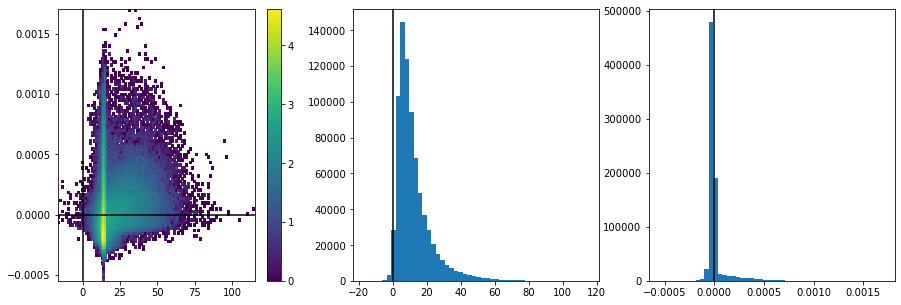

In [97]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].pcolor(xedg,yedg,np.log10(HIST))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')

ax[1].hist(x,bins=50);
ax[1].axvline(x=0,color='k')

ax[2].hist(y,bins=50);
ax[2].axvline(x=0,color='k')

In [100]:
x = datap4K.SHFLX[:,26:40,:].values.flatten()
y = datap4K.TPHYSTND[:,18,26:40,:].values.flatten()
HIST,xedg,yedg = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:2: RuntimeWarning: divide by zero encountered in log10
  # Generated by: tensorflow/python/tools/api/generator/create_python_api.py script.


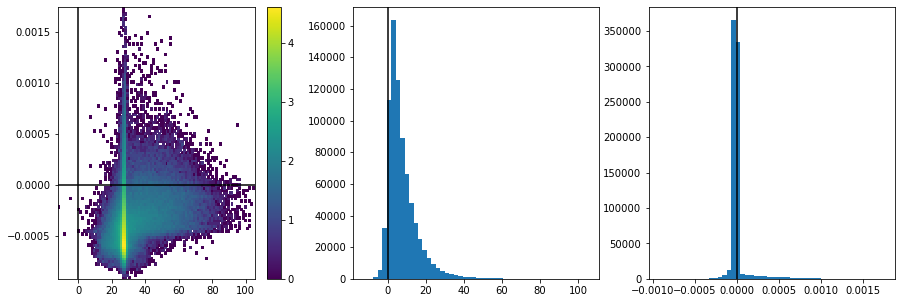

In [101]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].pcolor(xedg,yedg,np.log10(HIST))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')

ax[1].hist(x,bins=50);
ax[1].axvline(x=0,color='k')

ax[2].hist(y,bins=50);
ax[2].axvline(x=0,color='k')

### Surface Buoyancy Flux

Snipets from SPCAM3 code

```bflx = shf(i)/cpair + 0.61*state%t(i,pver)*lhf(i)/latvap```

```cpair = 1.00464e3```

```SHR_CONST_LATVAP = 2.501e6```

```pver``` is lowest level (highest pressure)

In [1]:
def bflx(shf,lhf,tns):
    '''
    Returns buoyancy flux from sensible heat flux (shf), 
    latent heaf flux (lhf)
    and near-surface temperature (tns)
    '''
    cpair = 1.00464e3
    latvap = 2.501e6
    
    return shf/cpair+0.61*tns*lhf/latvap

In [7]:
BFLX_m4K = bflx(datam4K.SHFLX,datam4K.LHFLX,datam4K.TAP[:,-1,:,:])

In [8]:
BFLX_p4K = bflx(datap4K.SHFLX,datap4K.LHFLX,datap4K.TAP[:,-1,:,:])

Relationship to SHF

In [9]:
x = datam4K.SHFLX.values.flatten()
y = BFLX_m4K.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

x = datap4K.SHFLX.values.flatten()
y = BFLX_p4K.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


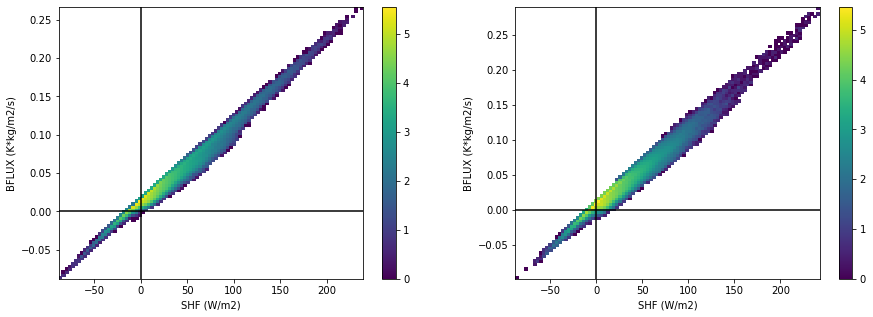

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_xlabel('SHF (W/m2)');
ax[0].set_ylabel('BFLUX (K*kg/m2/s)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_xlabel('SHF (W/m2)');
ax[1].set_ylabel('BFLUX (K*kg/m2/s)');

In [13]:
x = datam4K.LHFLX.values.flatten()
y = BFLX_m4K.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

x = datap4K.LHFLX.values.flatten()
y = BFLX_p4K.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


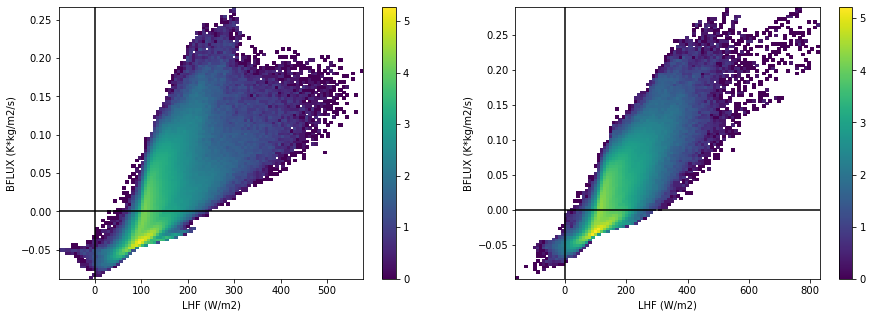

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_xlabel('LHF (W/m2)');
ax[0].set_ylabel('BFLUX (K*kg/m2/s)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_xlabel('LHF (W/m2)');
ax[1].set_ylabel('BFLUX (K*kg/m2/s)');

In [15]:
x = datam4K.LHFLX.values.flatten()+datam4K.SHFLX.values.flatten()
y = BFLX_m4K.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

x = datap4K.LHFLX.values.flatten()+datap4K.SHFLX.values.flatten()
y = BFLX_p4K.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


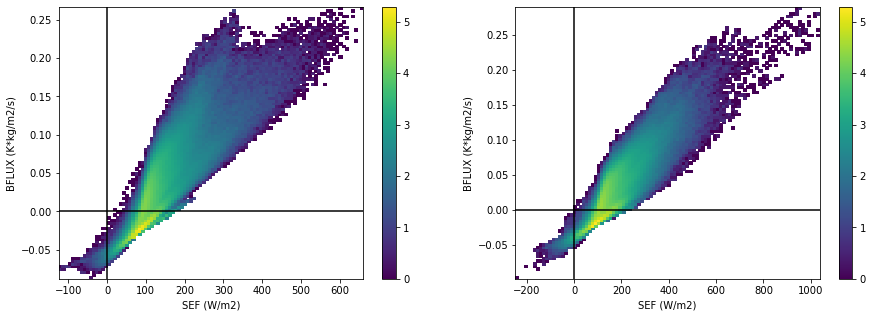

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_xlabel('SEF (W/m2)');
ax[0].set_ylabel('BFLUX (K*kg/m2/s)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_xlabel('SEF (W/m2)');
ax[1].set_ylabel('BFLUX (K*kg/m2/s)');

Conclusion 1: ```BFLX>0``` implies ```LHF>0``` and almost always implies ```SEF>0``` meaning we can safely normalize by either ```LHF``` or ```SEF``` after classifying samples using ```BFLX```

We now need to test whether ```BFLX>0``` is well correlated with convection. For simplicity, we first measure convection using precip and MSE tendency above the PBL

In [20]:
y = 2.5e6*datam4K.PRECT.values.flatten()
x = BFLX_m4K.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

y = 2.5e6*datap4K.PRECT.values.flatten()
x = BFLX_p4K.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


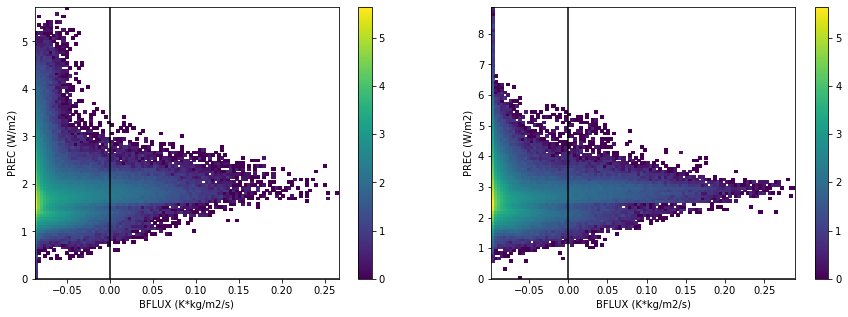

In [21]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_ylabel('PREC (W/m2)');
ax[0].set_xlabel('BFLUX (K*kg/m2/s)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_ylabel('PREC (W/m2)');
ax[1].set_xlabel('BFLUX (K*kg/m2/s)');

The precipitation, when it occurs, is usually related to a negative buoyancy flux. Logical as it causes a lot of reevaporation and cools the surface.

Now to the enthalpy tendency, which is what we may try normalizing by SEF based on BFLX classification

In [22]:
cpair = 1.00464e3
latvap = 2.501e6

ENTm4K = cpair*datam4K.TPHYSTND + latvap*datam4K.PHQ
ENTp4K = cpair*datap4K.TPHYSTND + latvap*datap4K.PHQ

Calculate dP to vertically integrate

In [43]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [55]:
g = 9.8

ENTm4K_FT = np.sum(ENTm4K*dP(datam4K.PS)/g,axis=1).values
ENTp4K_FT = np.sum(ENTp4K*dP(datap4K.PS)/g,axis=1).values

In [59]:
y = ENTm4K_FT.flatten()
x = BFLX_m4K.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

y = ENTp4K_FT.flatten()
x = BFLX_p4K.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


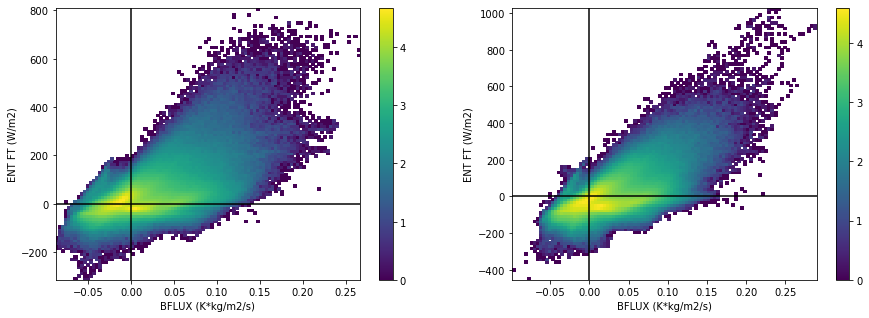

In [61]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_ylabel('ENT FT (W/m2)');
ax[0].set_xlabel('BFLUX (K*kg/m2/s)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_ylabel('ENT FT (W/m2)');
ax[1].set_xlabel('BFLUX (K*kg/m2/s)');

This is quite encouraging. Positive buoyancy fluxes correlate well with positive enthalpy tendencies in the free-troposphere

Let's see how total surface enthalpy fluxes correlate with the free-tropospheric enthalpy tendency

In [62]:
y = ENTm4K_FT.flatten()
x =  datam4K.LHFLX.values.flatten()+datam4K.SHFLX.values.flatten()
HISTm4K,xedgm4K,yedgm4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

y = ENTp4K_FT.flatten()
x =  datap4K.LHFLX.values.flatten()+datap4K.SHFLX.values.flatten()
HISTp4K,xedgp4K,yedgp4K = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:3: RuntimeWarning: divide by zero encountered in log10
  """Code for model cloning, plus model-related API entries.
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/api/_v1/keras/models/__init__.py:10: RuntimeWarning: divide by zero encountered in log10
  from tensorflow.python.keras import Sequential


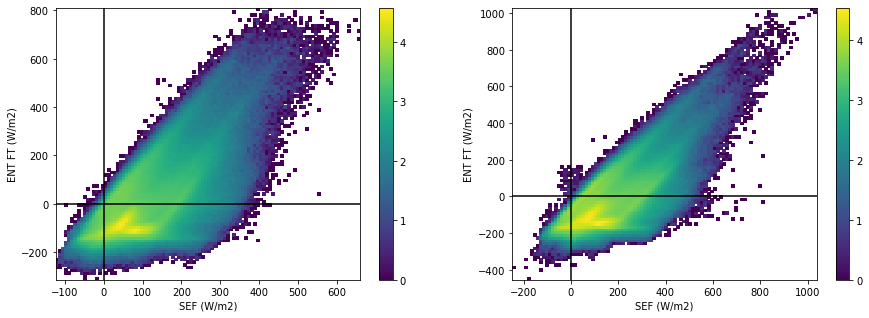

In [63]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].pcolor(xedgm4K,yedgm4K,np.log10(HISTm4K))
fig.colorbar(im,ax=ax[0])
ax[0].axvline(x=0,color='k')
ax[0].axhline(y=0,color='k')
ax[0].set_ylabel('ENT FT (W/m2)');
ax[0].set_xlabel('SEF (W/m2)');

im = ax[1].pcolor(xedgp4K,yedgp4K,np.log10(HISTp4K))
fig.colorbar(im,ax=ax[1])
ax[1].axvline(x=0,color='k')
ax[1].axhline(y=0,color='k')
ax[1].set_ylabel('ENT FT (W/m2)');
ax[1].set_xlabel('SEF (W/m2)');

### Lifted condensation level (from Romps)

```
# This lcl function returns the height of the lifting condensation level
# (LCL) in meters.  The inputs are:
# - p in Pascals
# - T in Kelvins
# - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
#    * The value of rh is interpreted to be the relative humidity with
#      respect to liquid water if T >= 273.15 K and with respect to ice if
#      T < 273.15 K. 
#    * The value of rhl is interpreted to be the relative humidity with
#      respect to liquid water
#    * The value of rhs is interpreted to be the relative humidity with
#      respect to ice
# - ldl is an optional logical flag.  If true, the lifting deposition
#   level (LDL) is returned instead of the LCL. 
# - min_lcl_ldl is an optional logical flag.  If true, the minimum of the
#   LCL and LDL is returned.

def lcl(p,T,rh=None,rhl=None,rhs=None,return_ldl=False,return_min_lcl_ldl=False):

   import math
   import scipy.special

   # Parameters
   Ttrip = 273.16     # K
   ptrip = 611.65     # Pa
   E0v   = 2.3740e6   # J/kg
   E0s   = 0.3337e6   # J/kg
   ggr   = 9.81       # m/s^2
   rgasa = 287.04     # J/kg/K 
   rgasv = 461        # J/kg/K 
   cva   = 719        # J/kg/K
   cvv   = 1418       # J/kg/K 
   cvl   = 4119       # J/kg/K 
   cvs   = 1861       # J/kg/K 
   cpa   = cva + rgasa
   cpv   = cvv + rgasv

   # The saturation vapor pressure over liquid water
   def pvstarl(T):
      return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * \
         math.exp( (E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T) )
   
   # The saturation vapor pressure over solid ice
   def pvstars(T):
      return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) * \
         math.exp( (E0v + E0s - (cvv-cvs)*Ttrip) / rgasv * (1/Ttrip - 1/T) )

   # Calculate pv from rh, rhl, or rhs
   rh_counter = 0
   if rh  is not None:
      rh_counter = rh_counter + 1
   if rhl is not None:
      rh_counter = rh_counter + 1
   if rhs is not None:
      rh_counter = rh_counter + 1
   if rh_counter != 1:
      print(rh_counter)
      exit('Error in lcl: Exactly one of rh, rhl, and rhs must be specified')
   if rh is not None:
      # The variable rh is assumed to be 
      # with respect to liquid if T > Ttrip and 
      # with respect to solid if T < Ttrip
      if T > Ttrip:
         pv = rh * pvstarl(T)
      else:
         pv = rh * pvstars(T)
      rhl = pv / pvstarl(T)
      rhs = pv / pvstars(T)
   elif rhl is not None:
      pv = rhl * pvstarl(T)
      rhs = pv / pvstars(T)
      if T > Ttrip:
         rh = rhl
      else:
         rh = rhs
   elif rhs is not None:
      pv = rhs * pvstars(T)
      rhl = pv / pvstarl(T)
      if T > Ttrip:
         rh = rhl
      else:
         rh = rhs
   if pv > p:
      return NA

   # Calculate lcl_liquid and lcl_solid
   qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
   rgasm = (1-qv)*rgasa + qv*rgasv
   cpm = (1-qv)*cpa + qv*cpv
   if rh == 0:
      return cpm*T/ggr
   aL = -(cpv-cvl)/rgasv + cpm/rgasm
   bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
   cL = pv/pvstarl(T)*math.exp(-(E0v-(cvv-cvl)*Ttrip)/(rgasv*T))
   aS = -(cpv-cvs)/rgasv + cpm/rgasm
   bS = -(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T)
   cS = pv/pvstars(T)*math.exp(-(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T))
   lcl = cpm*T/ggr*( 1 - \
      bL/(aL*scipy.special.lambertw(bL/aL*cL**(1/aL),-1).real) )
   ldl = cpm*T/ggr*( 1 - \
      bS/(aS*scipy.special.lambertw(bS/aS*cS**(1/aS),-1).real) )

   # Return either lcl or ldl
   if return_ldl and return_min_lcl_ldl:
      exit('return_ldl and return_min_lcl_ldl cannot both be true')
   elif return_ldl:
      return ldl
   elif return_min_lcl_ldl:
      return min(lcl,ldl)
   else:
      return lcl
```

### Equivalent potential temperature

From Emanuel's ```Atmospheric Convection``` book (1994)

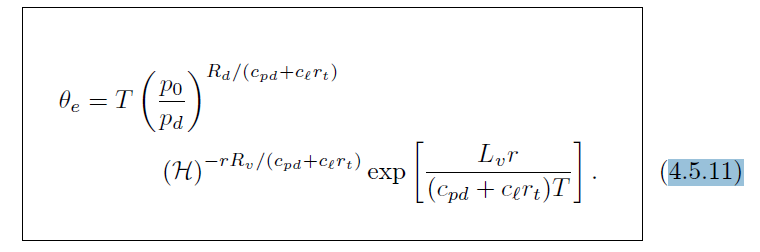

From Romps and Kuang (2010)

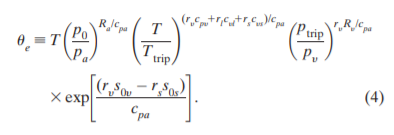

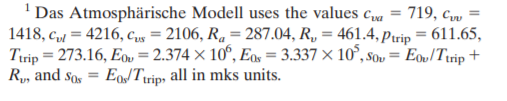

Despite Romps and Kuang's definition being more transparent about its reference state (the triple point of water), we'll proceed with the Emanuel definition for simplicity

In [64]:
# Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
C_L = 4.188e3 # Specific heat capacite of fresh water at constant pressure
L_V = 2.501e6   # Latent heat of vaporization
P0 = 1e5 # Reference pressure
R = np.float32(287.0)
Rv = np.float32(461.0)

In [120]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

In [117]:
def EPT(T,qv,ql,qi,P0,PS,hyam,hybm):
    
    C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
    C_L = 4.188e3 # Specific heat capacite of fresh water at constant pressure
    L_V = 2.501e6   # Latent heat of vaporization
    R = np.float32(287.0)
    Rv = np.float32(461.0);
    
    P = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    RH0 = RH(T,qv,P0,PS,hyam,hybm)
    r0 = qv/(1-qv)
    rt0 = (qv+ql+qi)/(1-qv-ql-qi)
    
    P00 = np.moveaxis(np.tile(datam4K.P0.values,(1,1,1,1)),3,0)
    return T*((P00/P)**(R/(C_P+C_L*rt0)))*(RH0**(-r0*Rv/(C_P+C_L*rt0)))*np.exp(L_V*r0/(T*(C_P+C_L*rt0)))

In [119]:
EPT0 = EPT(datam4K.TAP.values,datam4K.QAP,datam4K.QCAP,
           datam4K.QIAP,
           datam4K.P0,datam4K.PS,
           datam4K.hyam,datam4K.hybm)

p (432, 30, 64, 128)
qv (432, 30, 64, 128)
esat (432, 30, 64, 128)


In [122]:
EPT4 = EPT(datap4K.TAP.values,datap4K.QAP,datap4K.QCAP,
           datap4K.QIAP,
           datap4K.P0,datap4K.PS,
           datap4K.hyam,datap4K.hybm)

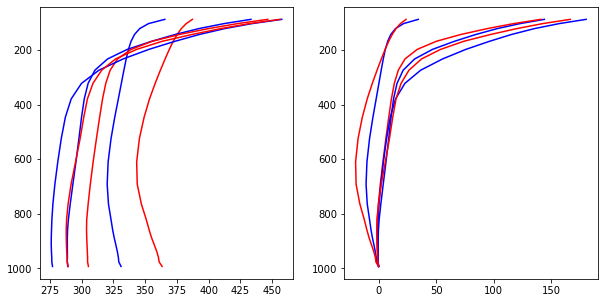

In [127]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.mean(EPT0[:,7:,26:40,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(EPT4[:,7:,26:40,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].plot(np.mean(EPT0[:,7:,13:20,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(EPT4[:,7:,13:20,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].plot(np.mean(EPT0[:,7:,0:7,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(EPT4[:,7:,0:7,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].invert_yaxis()

ax[1].plot(np.mean(EPT0[:,7:,26:40,:],axis=(0,2,3))-np.mean(EPT0[:,-1,26:40,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(EPT4[:,7:,26:40,:],axis=(0,2,3))-np.mean(EPT4[:,-1,26:40,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].plot(np.mean(EPT0[:,7:,13:20,:],axis=(0,2,3))-np.mean(EPT0[:,-1,13:20,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(EPT4[:,7:,13:20,:],axis=(0,2,3))-np.mean(EPT4[:,-1,13:20,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].plot(np.mean(EPT0[:,7:,0:7,:],axis=(0,2,3))-np.mean(EPT0[:,-1,0:7,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(EPT4[:,7:,0:7,:],axis=(0,2,3))-np.mean(EPT4[:,-1,0:7,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].invert_yaxis()

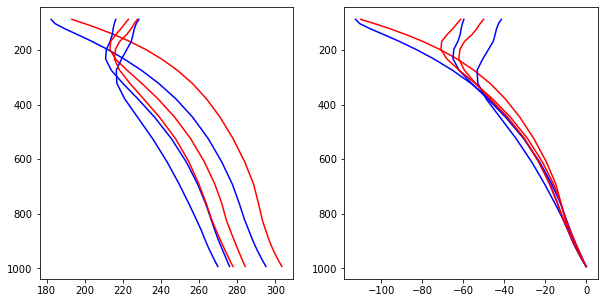

In [128]:
T0 = datam4K.TAP.values
T4 = datap4K.TAP.values

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.mean(T0[:,7:,26:40,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(T4[:,7:,26:40,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].plot(np.mean(T0[:,7:,13:20,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(T4[:,7:,13:20,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].plot(np.mean(T0[:,7:,0:7,:],axis=(0,2,3)),datam4K.lev[7:],color='b')
ax[0].plot(np.mean(T4[:,7:,0:7,:],axis=(0,2,3)),datam4K.lev[7:],color='r')
ax[0].invert_yaxis()

ax[1].plot(np.mean(T0[:,7:,26:40,:],axis=(0,2,3))-np.mean(T0[:,-1,26:40,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(T4[:,7:,26:40,:],axis=(0,2,3))-np.mean(T4[:,-1,26:40,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].plot(np.mean(T0[:,7:,13:20,:],axis=(0,2,3))-np.mean(T0[:,-1,13:20,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(T4[:,7:,13:20,:],axis=(0,2,3))-np.mean(T4[:,-1,13:20,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].plot(np.mean(T0[:,7:,0:7,:],axis=(0,2,3))-np.mean(T0[:,-1,0:7,:],axis=(0,1,2)),
           datam4K.lev[7:],color='b')
ax[1].plot(np.mean(T4[:,7:,0:7,:],axis=(0,2,3))-np.mean(T4[:,-1,0:7,:],axis=(0,1,2)),
           datam4K.lev[7:],color='r')
ax[1].invert_yaxis()

### Lapse rate

In [136]:
def PI(PS):    
    S = PS.shape
    return 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)

In [166]:
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616

PIm4 = PI(datam4K.PS)
TIm4 = np.concatenate((datam4K.TAP,np.expand_dims(datam4K.TS,axis=1)),axis=1)
dTdpm4 = -C_P/G*(TIm4[:,1:,:,:]-TIm4[:,:-1,:,:])/(PIm4[:,1:,:,:]-PIm4[:,:-1,:,:])

In [167]:
PIp4 = PI(datap4K.PS)
TIp4 = np.concatenate((datap4K.TAP,np.expand_dims(datap4K.TS,axis=1)),axis=1)
dTdpp4 = -C_P/G*(TIp4[:,1:,:,:]-TIp4[:,:-1,:,:])/(PIp4[:,1:,:,:]-PIp4[:,:-1,:,:])

In [157]:
def EPTsur(TS,PS,hyam,hybm):
    
    C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
    C_L = 4.188e3 # Specific heat capacite of fresh water at constant pressure
    L_V = 2.501e6   # Latent heat of vaporization
    R = np.float32(287.0)
    Rv = np.float32(461.0);
    
    qv = R/Rv*esat(TS)/PS.values
    r0 = qv/(1-qv)
    
    return TS*np.exp(L_V*r0/(TS*(C_P+C_L*r0)))

In [158]:
EPTsur(datam4K.TS.values,datam4K.PS,datam4K.hyam,datam4K.hybm).shape

(432, 64, 128)

In [160]:
EPTIm4 = np.concatenate((EPT0,
                         np.expand_dims(EPTsur(datam4K.TS.values,datam4K.PS,datam4K.hyam,datam4K.hybm),axis=1)),
                        axis=1)

In [161]:
EPTIp4 = np.concatenate((EPT4,
                         np.expand_dims(EPTsur(datap4K.TS.values,datap4K.PS,datap4K.hyam,datap4K.hybm),axis=1)),
                        axis=1)

In [164]:
dEPTdpm4 = -C_P/G*(EPTIm4[:,1:,:,:]-EPTIm4[:,:-1,:,:])/(PIm4[:,1:,:,:]-PIm4[:,:-1,:,:])

In [165]:
dEPTdpp4 = -C_P/G*(EPTIp4[:,1:,:,:]-EPTIp4[:,:-1,:,:])/(PIp4[:,1:,:,:]-PIp4[:,:-1,:,:])

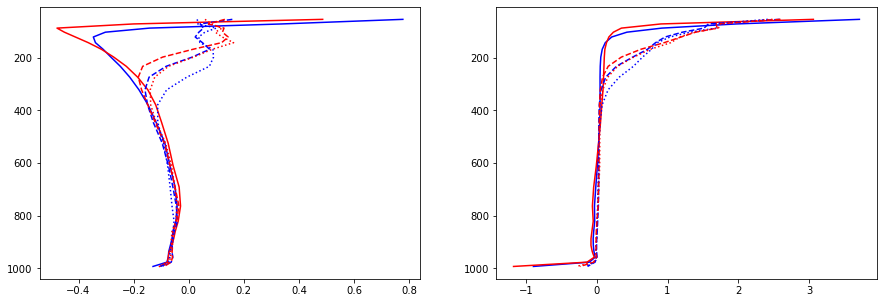

In [168]:
ilow = 5

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.mean(dTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[0].plot(np.mean(dTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[0].plot(np.mean(dTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[0].plot(np.mean(dTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[0].plot(np.mean(dTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[0].plot(np.mean(dTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[0].invert_yaxis()

ax[1].plot(np.mean(dEPTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[1].plot(np.mean(dEPTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[1].plot(np.mean(dEPTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[1].plot(np.mean(dEPTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[1].plot(np.mean(dEPTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[1].plot(np.mean(dEPTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[1].invert_yaxis()

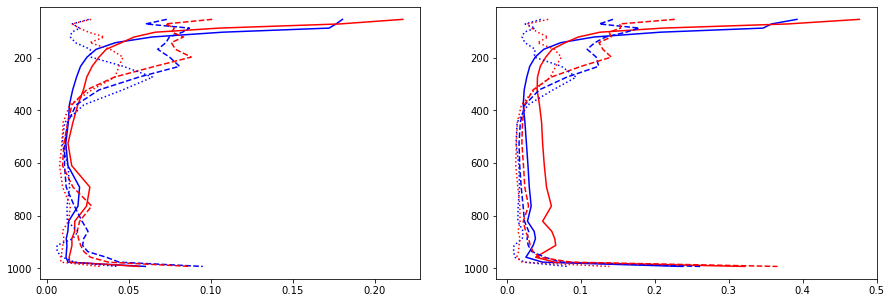

In [169]:
ilow = 5

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.std(dTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[0].plot(np.std(dTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[0].plot(np.std(dTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[0].plot(np.std(dTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[0].plot(np.std(dTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[0].plot(np.std(dTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[0].invert_yaxis()

ax[1].plot(np.std(dEPTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[1].plot(np.std(dEPTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[1].plot(np.std(dEPTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[1].plot(np.std(dEPTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[1].plot(np.std(dEPTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[1].plot(np.std(dEPTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[1].invert_yaxis()

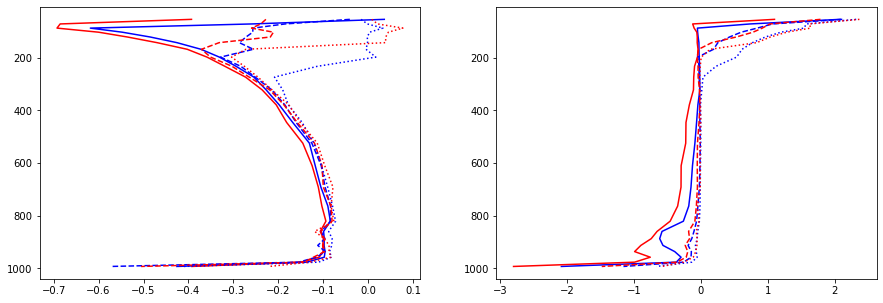

In [170]:
ilow = 5

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.min(dTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[0].plot(np.min(dTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[0].plot(np.min(dTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[0].plot(np.min(dTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[0].plot(np.min(dTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[0].plot(np.min(dTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[0].invert_yaxis()

ax[1].plot(np.min(dEPTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[1].plot(np.min(dEPTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[1].plot(np.min(dEPTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[1].plot(np.min(dEPTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[1].plot(np.min(dEPTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[1].plot(np.min(dEPTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[1].invert_yaxis()

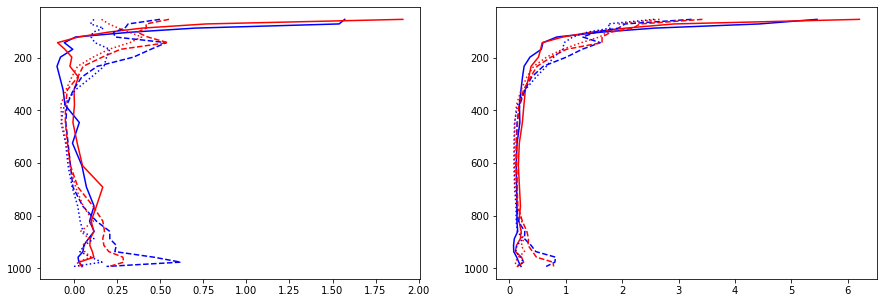

In [171]:
ilow = 5

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.max(dTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[0].plot(np.max(dTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[0].plot(np.max(dTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[0].plot(np.max(dTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[0].plot(np.max(dTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[0].plot(np.max(dTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[0].invert_yaxis()

ax[1].plot(np.max(dEPTdpm4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b')
ax[1].plot(np.max(dEPTdpp4[:,ilow:,26:40,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r')
ax[1].plot(np.max(dEPTdpm4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle='--')
ax[1].plot(np.max(dEPTdpp4[:,ilow:,13:20,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle='--')
ax[1].plot(np.max(dEPTdpm4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='b',linestyle=':')
ax[1].plot(np.max(dEPTdpp4[:,ilow:,0:7,:],axis=(0,2,3)),datam4K.lev[ilow:],color='r',linestyle=':')
ax[1].invert_yaxis()

In [138]:
PIm4.shape

(432, 31, 64, 128)

In [132]:
np.expand_dims(datam4K.TS,axis=1).shape

(432, 1, 64, 128)

In [130]:
dPm4.shape

(432, 30, 64, 128)

### Playing with latent heat flux normalization

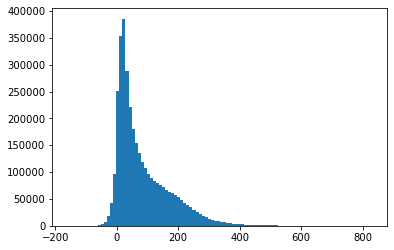

In [106]:
plt.hist(datap4K.LHFLX[:,:,:].values.flatten(),bins=100);

In [110]:
[datap4K.LHFLX<0]

[<xarray.DataArray 'LHFLX' (time: 432, lat: 64, lon: 128)>
 dask.array<shape=(432, 64, 128), dtype=bool, chunksize=(48, 64, 128)>
 Coordinates:
   * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
   * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
   * time     (time) float64 365.0 365.0 365.0 365.1 ... 373.9 373.9 374.0 374.0]

In [107]:
# When in LHF negative?

In [109]:
plt.plot(datap4K.lat,np.sum(datap4K.LHFLX[datap4K.LHFLX<0]))

IndexError: 3-dimensional boolean indexing is not supported. 

In [ ]:
x = datam4K.SHFLX[:,26:40,:].values.flatten()
y = datam4K.TPHYSTND[:,18,26:40,:].values.flatten()
HIST,xedg,yedg = np.histogram2d(x, y, bins=100, range=None, normed=None, weights=None, density=None)